Collins Kanyiri

## Business Problem

Our team of data scientists work together on a team for a new growing movie platform looking to compete with other giants such as Netflix, Hulu, and HBO. Our aim is to create a unique experience for each of our customers while subtly increasing our ROI. We aim to achieve this by building a tailored, unique recommendation system that can effectively suggest movies to our users, in order to continue to engage them with our platform. We want to be able to make predictions to our existing clients, as well as use our recommendation system as a product we use to attract new users to our platform. Additionally, as we continue to build up our recommendation systems, we plan to build our platform by investing in newer content for users to enjoy.

In [1]:
#Import relevant packages
import pandas as pd
import seaborn as sns
import numpy as np

from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import the movies csv file 
movies = pd.read_csv('movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#Import the ratings csv file 
ratings = pd.read_csv('ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
tags = pd.read_csv('tags.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
#Merge movies and ratings dataframes for easier reference.
df = pd.merge(ratings, movies, on='movieId', how='left').merge(tags, on = ['movieId', 'userId'], how = 'left')
df

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN
...,...,...,...,...,...,...,...,...
102672,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller,NaN,NaN
102673,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller,Heroic Bloodshed,1.493844e+09
102674,610,168250,5.0,1494273047,Get Out (2017),Horror,NaN,NaN
102675,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,NaN,NaN


In [6]:
#df = df_MR.merge(tags, on = ['movieId', 'userId'], how = 'left')

In [7]:
#Add a feature 'year' that shows which year the movie is from 
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
df.head(5)

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,1995


In [8]:
#Unique values in dataframe
df.nunique()

userId           610
movieId         9724
rating            10
timestamp_x    85043
title           9719
genres           951
tag             1543
timestamp_y     3219
year             107
dtype: int64

In [9]:
#Drop 'timestamp' as this column is unnecessary
data = df.drop(['timestamp_x', 'timestamp_y'], axis=1)

Before we continue, let us check on the sparsity of our matrix.

In [10]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9826899474681539

Our matrix is very sparse; 98%. We will now filter the data frame to deal with sparsity and create a denser utility matrix, by removing users who have provided a low number of ratings (less than 100) and movies that were rated less frequently (less than 10 times).

In [11]:
#Filter out users who have rated less than 200 movies 
data = data.groupby('userId').filter(lambda x: len(x)>100)

#Filter out movies who have rated less than 10 times 
data = data.groupby('movieId').filter(lambda x: len(x)>10)

recheck the sparsity of our matrix.


In [12]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.8668616564214422

This result looks pretty good; our resulting matrix is much less sparse, at 79%

In [13]:
#Check for NA values 
data.isna().sum()

userId         0
movieId        0
rating         0
title          0
genres         0
tag        61963
year           0
dtype: int64

## EDA

Firstly, let's take a look at which years were the most popular for movies in our dataset.

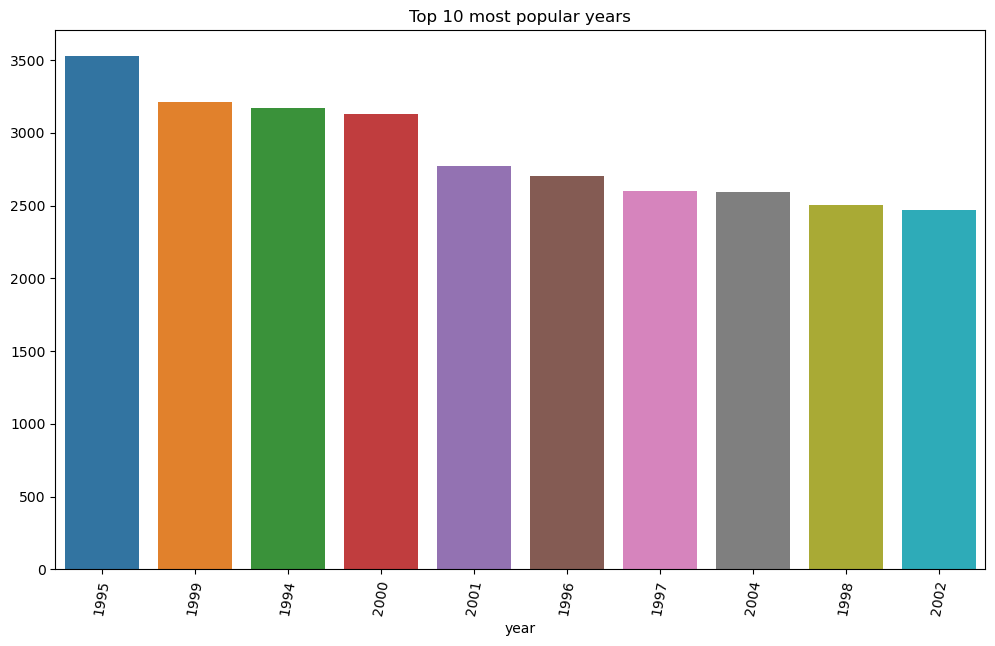

In [14]:
#Top 10 Years with the most movies produced.
plt.figure(figsize=(12,7))
topyear = data.groupby('year').size().sort_values(ascending=False).head(10)
sns.barplot(x=topyear.index, y=topyear.values)
plt.title('Top 10 most popular years')
plt.xticks(rotation=80);


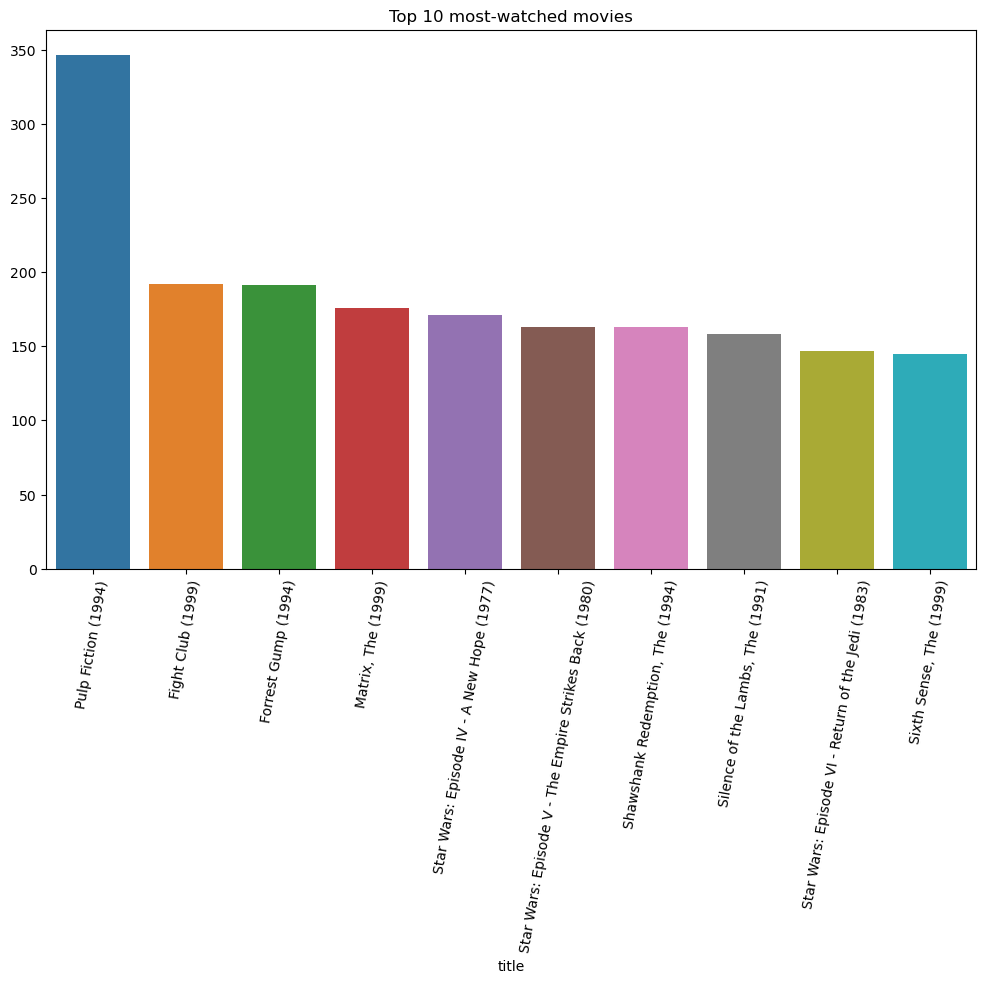

In [15]:
#Plot the top 10 most watched movies
plt.figure(figsize=(12,7))
topmovies = data.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(x=topmovies.index, y=topmovies.values)
plt.title('Top 10 most-watched movies')
plt.xticks(rotation=80);

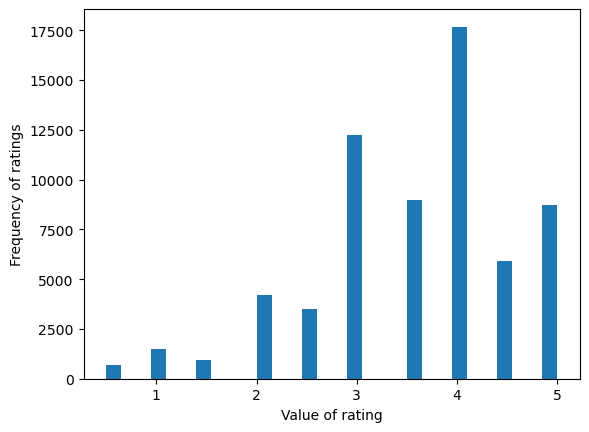

In [16]:
#Plot a histogram of the frequency of certain rating values
plt.hist(data['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

#### genre

Interested to see how many unique genre combinations we have:

In [17]:
len(movies['genres'].unique())

951

So there are 951 unique genre combinations

In [18]:
count_genres = {}
for genre in movies['genres']:
    count_genres[genre] = count_genres.get(genre, 0) + 1


Sort Genres by popularity

In [19]:
popular_genre = []
for genre in count_genres:
    if count_genres[genre] > 100:
        print(genre, count_genres[genre])
        popular_genre.append(genre)
print(len(popular_genre))

Comedy|Romance 363
Comedy|Drama|Romance 276
Comedy 946
Drama 1053
Crime|Drama 134
Drama|Romance 349
Drama|War 114
Drama|Thriller 168
Comedy|Crime 101
Comedy|Drama 435
Documentary 339
Crime|Drama|Thriller 125
Horror 167
Horror|Thriller 135
14


These are the top genre combinations

In [20]:
#Creat genre labels
genrelabels = set()
for i in data['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

genrelabels  

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [21]:
#Create function that counts how many movies there are of each genre 
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count        


#Apply the genrecounts formula to our dataset and print the resulting genres and their counts 
genre_count = genrecounts(data, 'genres', genrelabels)
genre_count


{'Action': 21964,
 'Drama': 25893,
 'Adventure': 17563,
 'Children': 6199,
 'Horror': 4205,
 'Fantasy': 8484,
 'Animation': 4699,
 'Musical': 2740,
 'Sci-Fi': 12934,
 'War': 3112,
 'Thriller': 18072,
 'Comedy': 25193,
 'Crime': 11474,
 'Romance': 11521,
 'Documentary': 304,
 'Mystery': 5374,
 'Film-Noir': 614,
 'Western': 1244,
 'IMAX': 3161}

In [22]:
#Create a dataframe for the genres and their value counts 
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

#Sort the DataFrame
genres = genres.sort_values(by=['Frequency'], ascending=False)

#Print the resulting DataFrame 
genres

,Genre,Frequency
1,Drama,25893
11,Comedy,25193
0,Action,21964
10,Thriller,18072
2,Adventure,17563
8,Sci-Fi,12934
13,Romance,11521
12,Crime,11474
5,Fantasy,8484
3,Children,6199


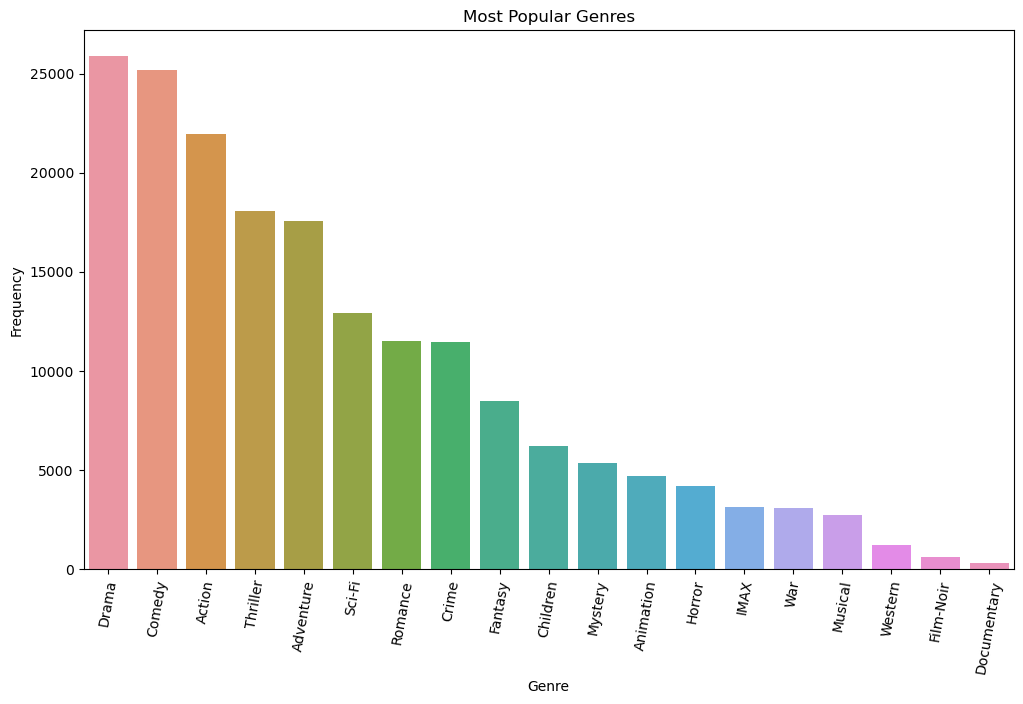

In [23]:
#Plot the top most watched movie genres
plt.figure(figsize=(12,7))
sns.barplot(x=genres['Genre'], y=genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=80);

We see that Comedy, Drama, and Action are the top 3 genres that are watched by viewers. Again, this information could involve popularity bias when conducting our models; our models may be prone to recommending films that are in Drama, Comedy and Action genres; therefore we must look out for this bias when recommending films to users with our models.

#### tags

In [24]:
count_tags = {}
for tag in tags['tag']:
    count_tags[tag] = count_tags.get(tag, 0) + 1



Let's look into the most common tags and find the top 20 tags.

In [25]:
popular_tag = []
for tag in count_tags:
    if count_tags[tag] > 0:
#         print(genre, count_genres[tag])
        popular_tag.append(tag)
print(len(popular_tag))

sorted_pop_tags = sorted(popular_tag, key=lambda x:x[1], reverse=True)

sorted_pop_tags[:20]

1589


['cyberpunk',
 'Mystery',
 'Ryan Reynolds',
 'dystopia',
 'ryan reynolds',
 'Dystopia',
 'system holism',
 'mystery',
 'cynical',
 'mythology',
 'Myth',
 'lyrical',
 'symbolism',
 'symbolic',
 'Exquisite plotting.',
 'ex-con',
 'existentialism',
 'Existential',
 'exciting',
 'twist ending']

We can see there's a lot of double ups here with tags that do and don't use capitilisation such asa 'Ryan Reynolds' vs. 'ryan reynolds'. As well as similar categories such as 'myth', 'mythology', even 'mystery'.
But since only a small set of the data is taged. we will drop the tag column

In [26]:
#Drop 'tag' column 
data = data.drop(['tag'], axis=1)
data

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995
...,...,...,...,...,...,...
102670,610,164179,5.0,Arrival (2016),Sci-Fi,2016
102671,610,166528,4.0,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,2016
102673,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller,2017
102674,610,168250,5.0,Get Out (2017),Horror,2017


#### users

In [27]:
#See which users have provided the most ratings
data['userId'].value_counts()

userId
599    1584
414    1498
474    1146
68     1044
448     951
       ... 
492      76
309      74
377      67
306      61
571      40
Name: count, Length: 246, dtype: int64

#### Additional EDA

In [28]:
#look at the original dataframe again
data.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [29]:
#Create columns for each genre to indicate T/F
for genre in genrelabels:
    data[genre] = data['genres'].apply(lambda x: genre in x)

In [30]:
#Create a logical matrix now that the genres have been parsed.
matrix = data.drop(['userId', 'movieId', 'rating', 'genres', 'year'], axis=1)
matrix.head(2)

,title,Action,Drama,Adventure,Children,Horror,Fantasy,Animation,Musical,Sci-Fi,War,Thriller,Comedy,Crime,Romance,Documentary,Mystery,Film-Noir,Western,IMAX
0,Toy Story (1995),False,False,True,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False
1,Grumpier Old Men (1995),False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False


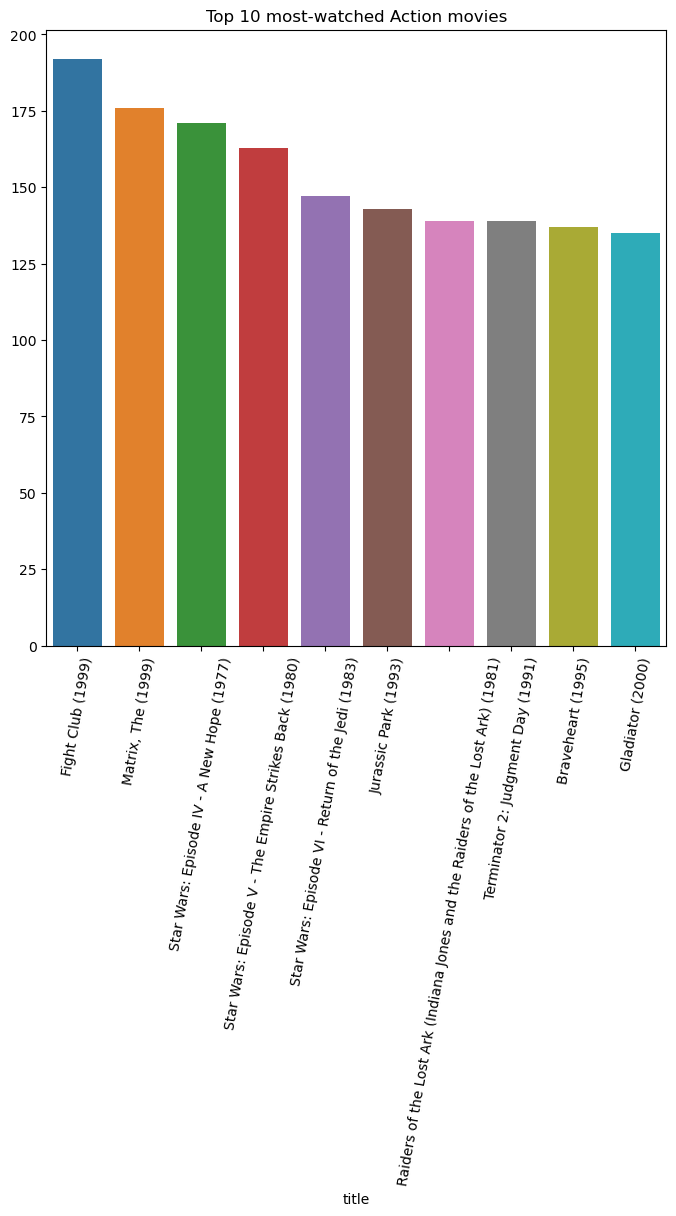

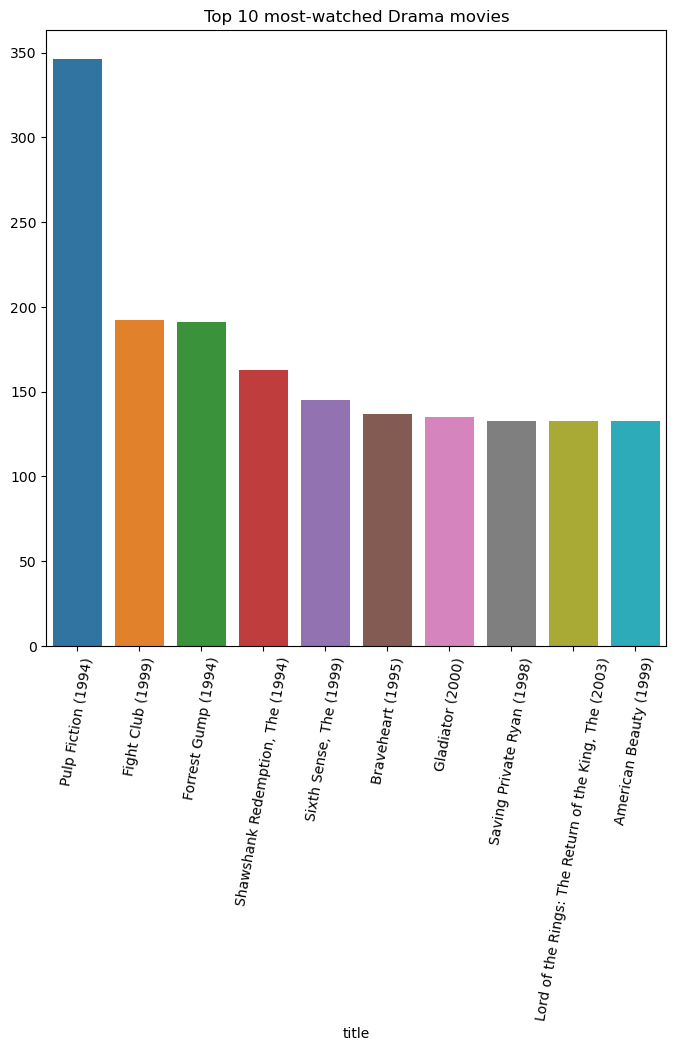

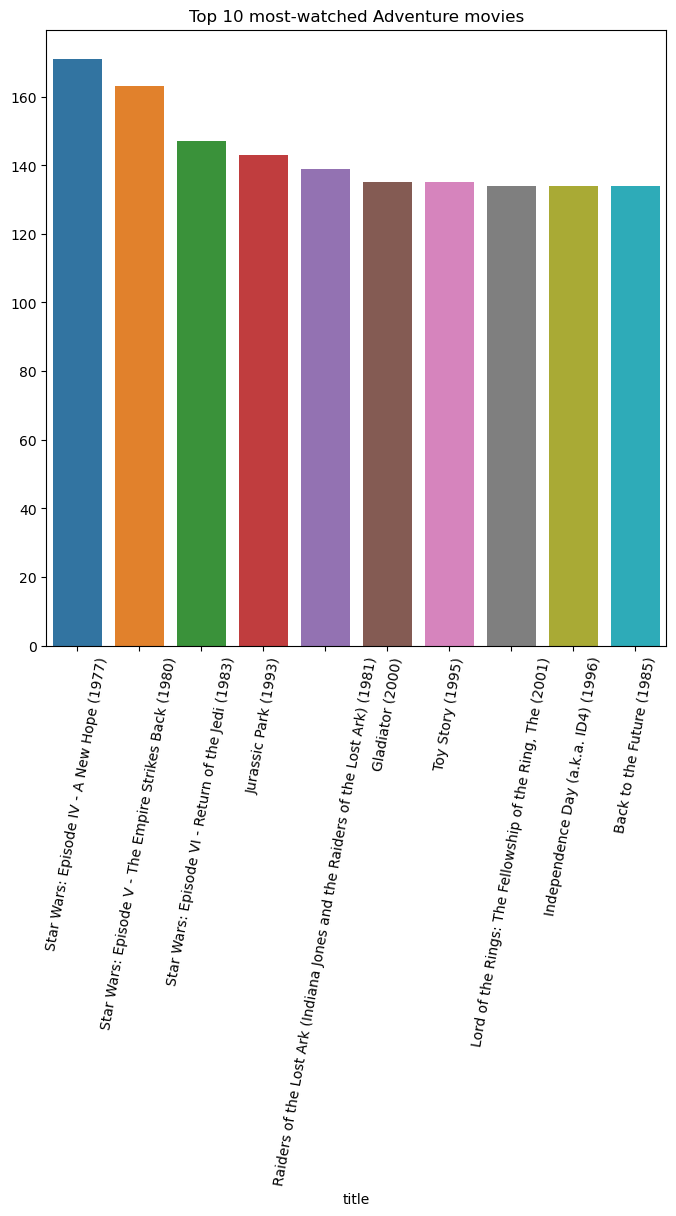

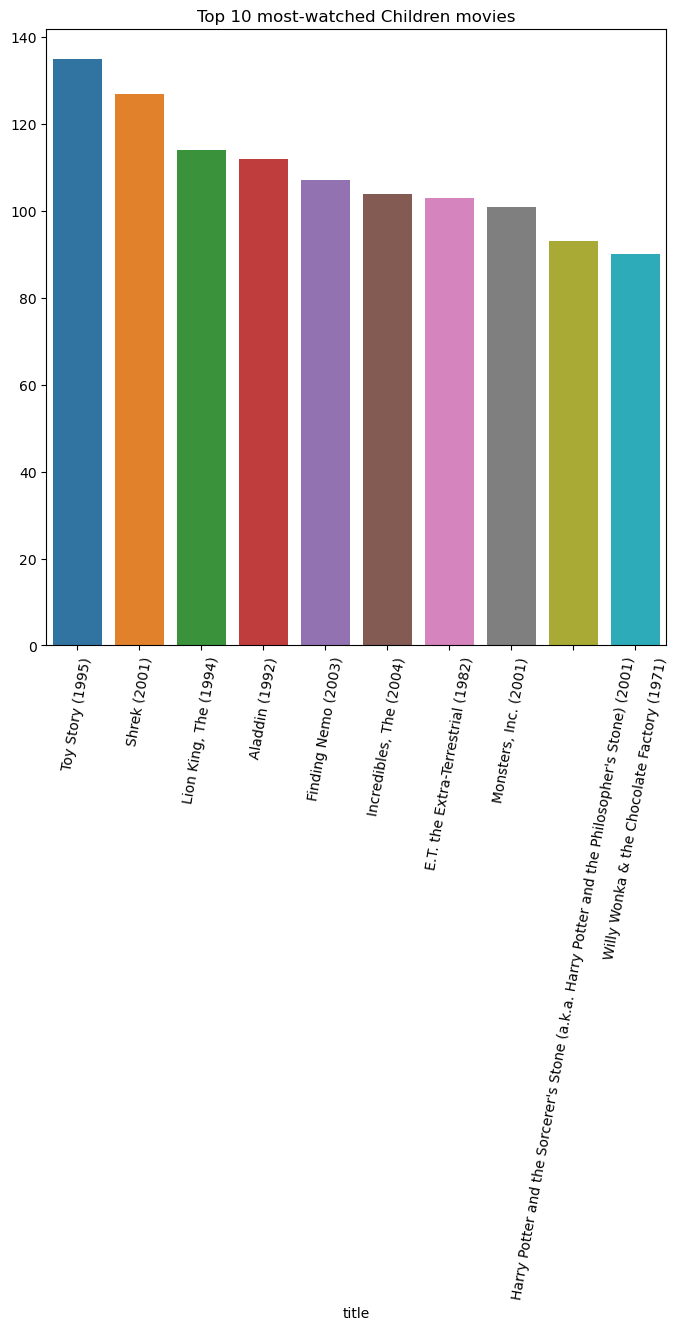

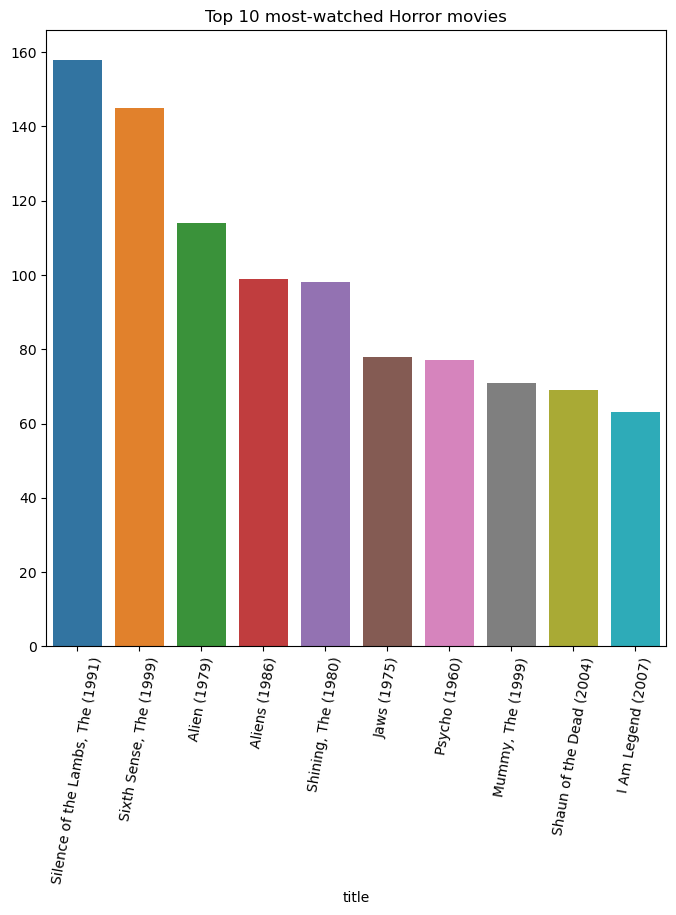

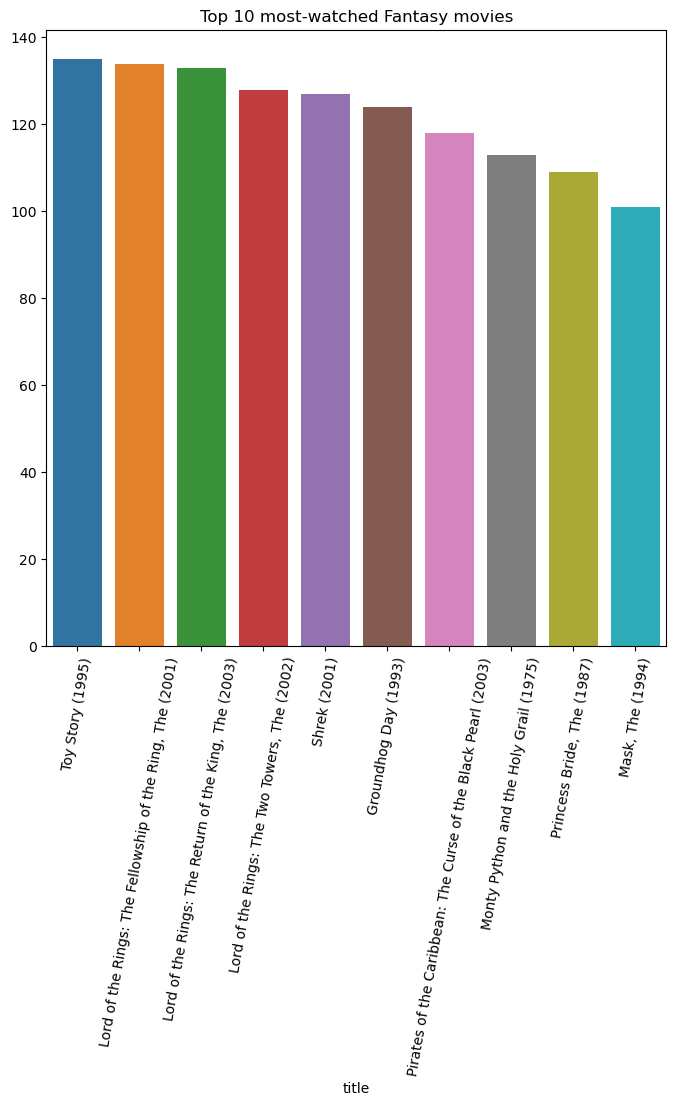

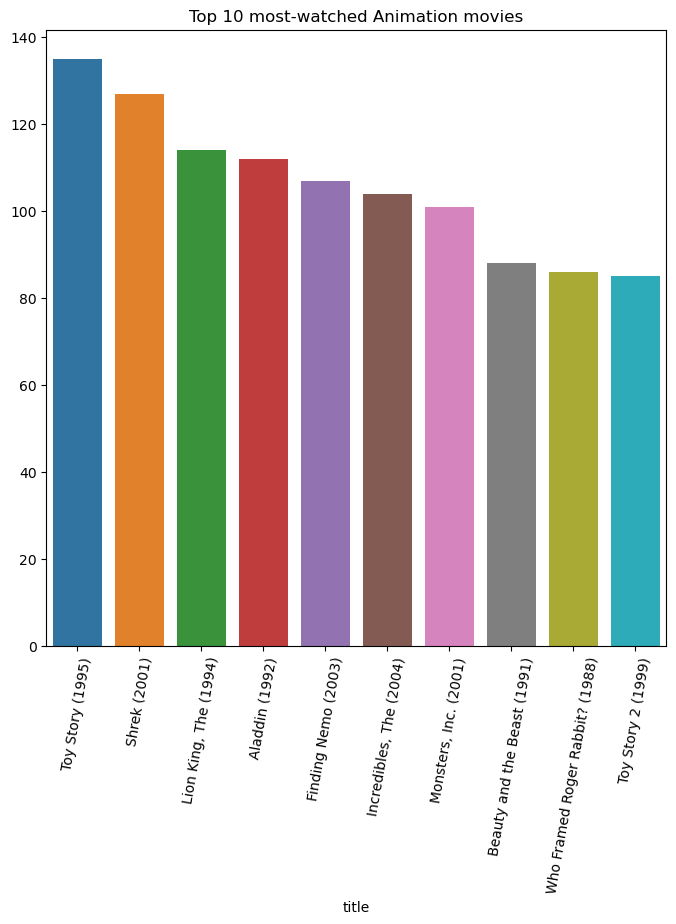

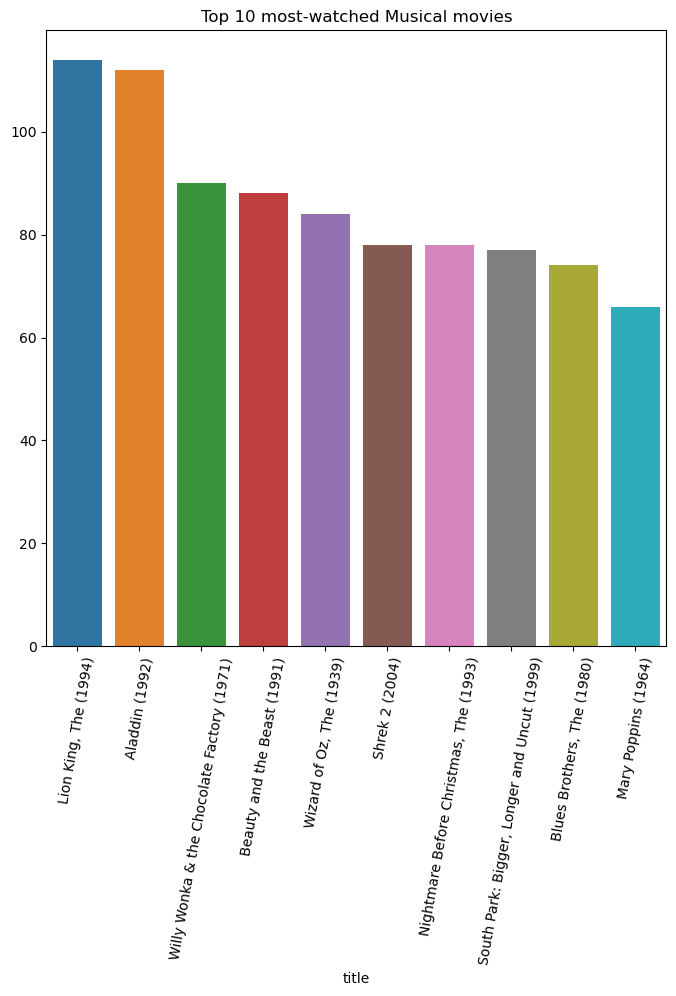

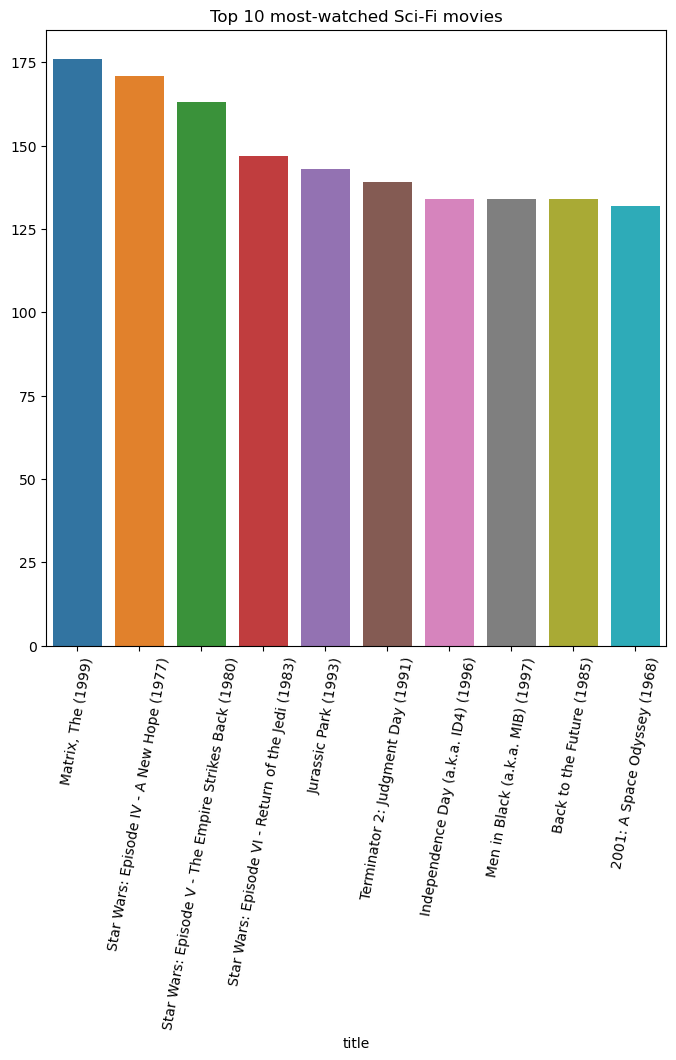

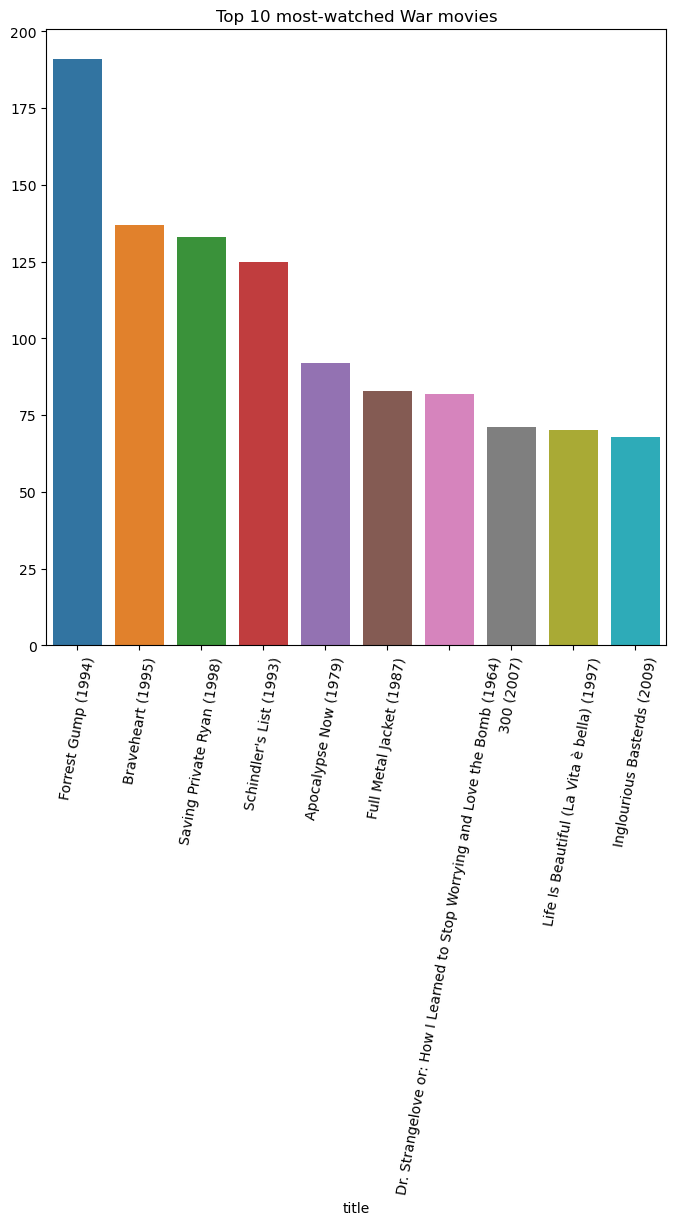

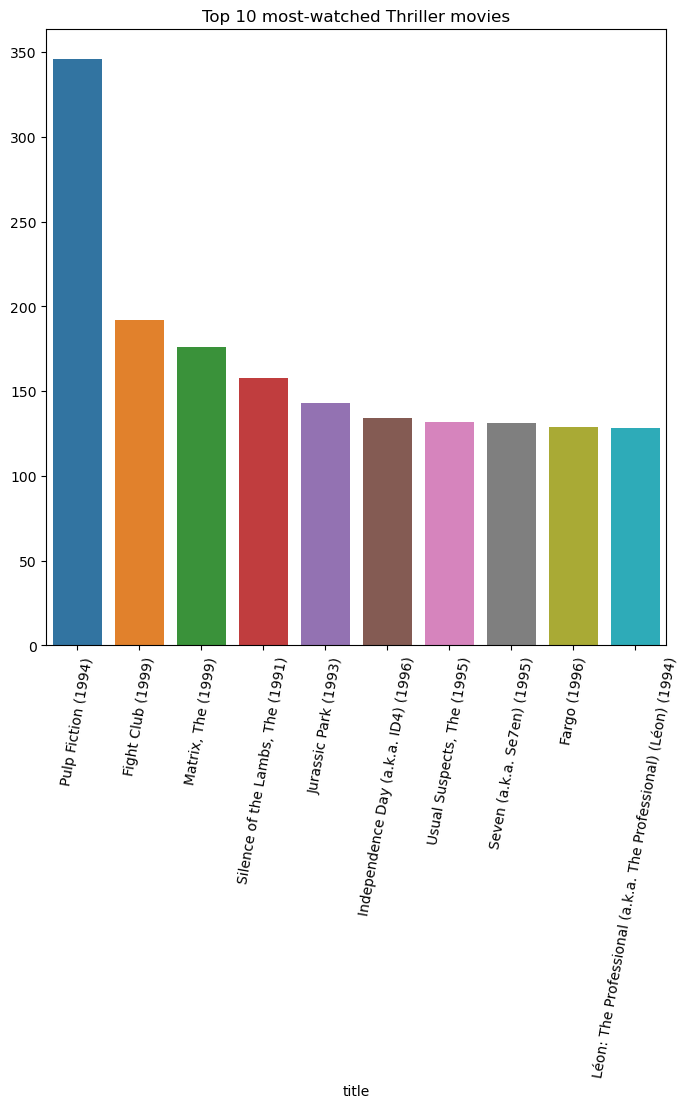

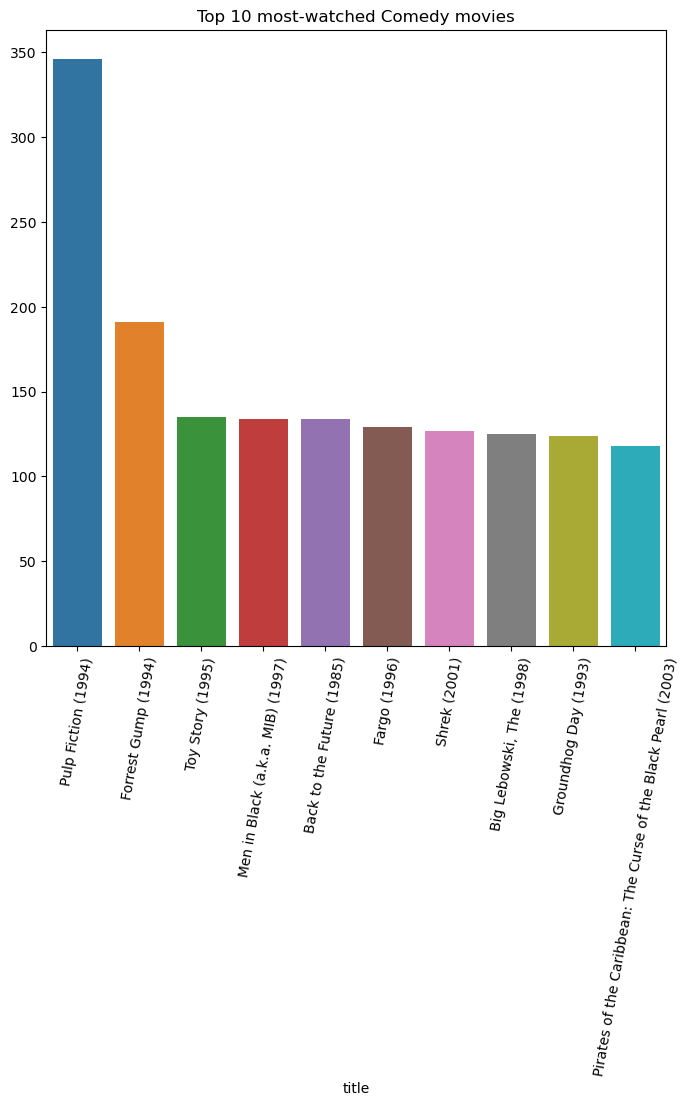

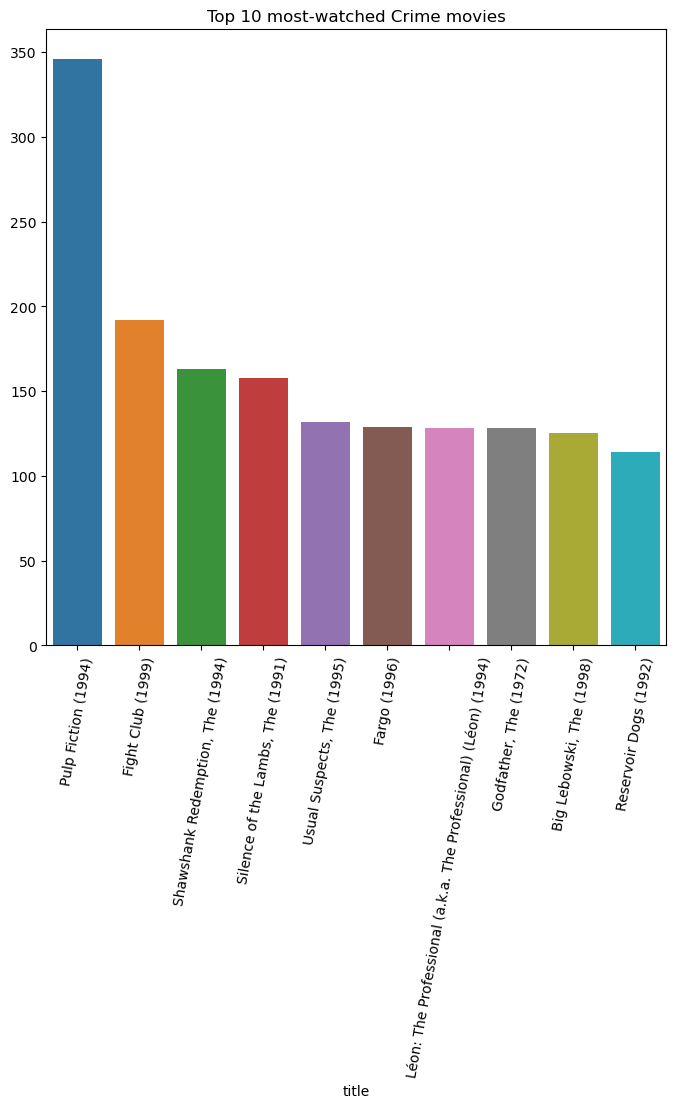

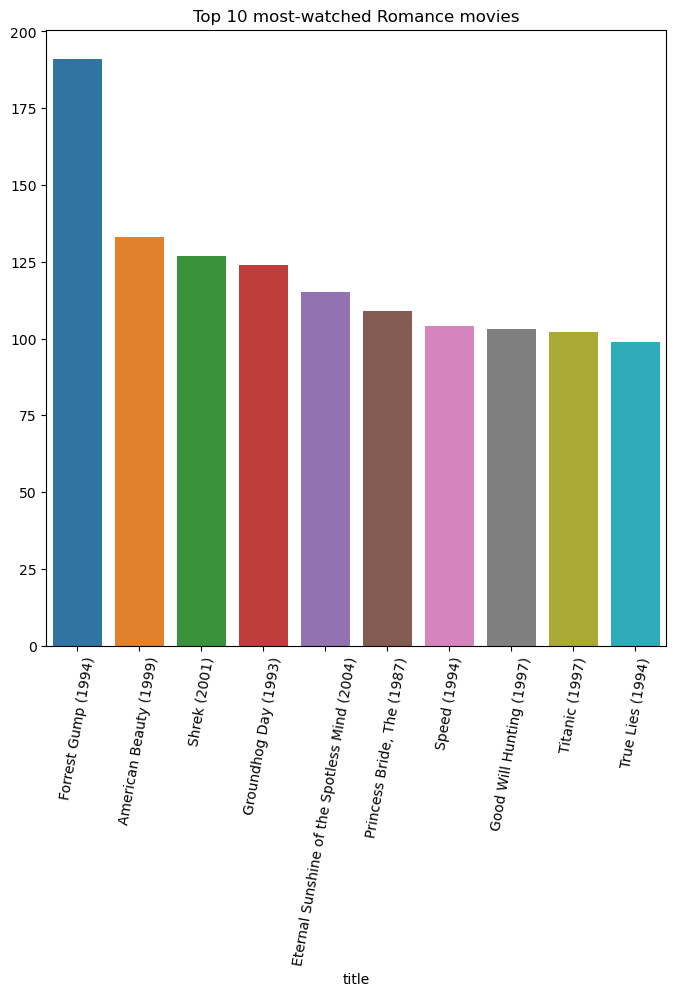

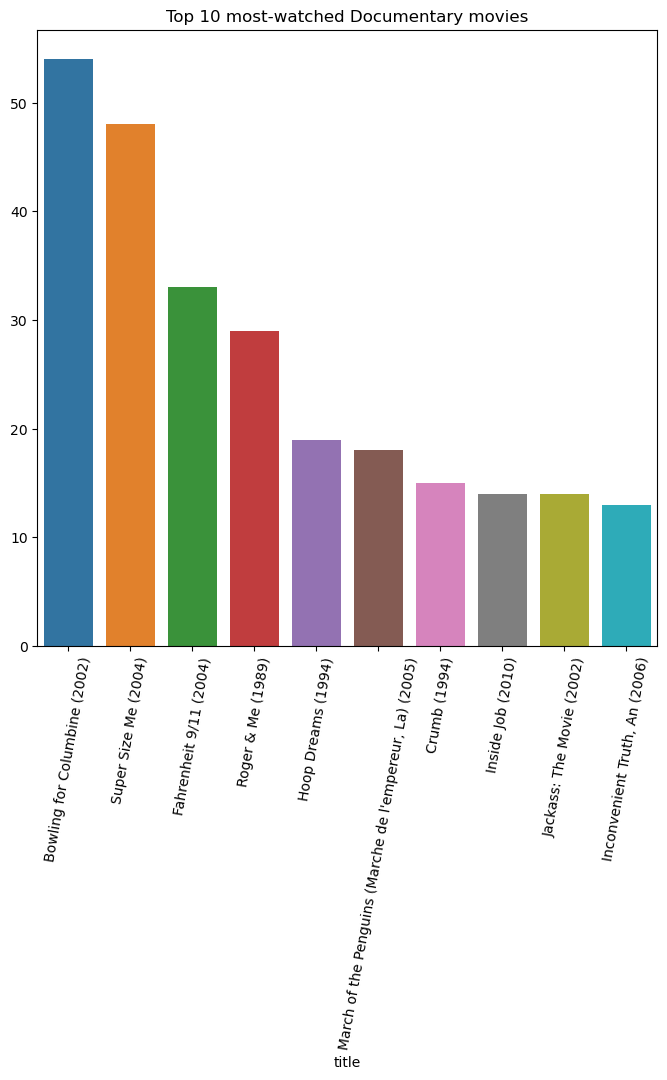

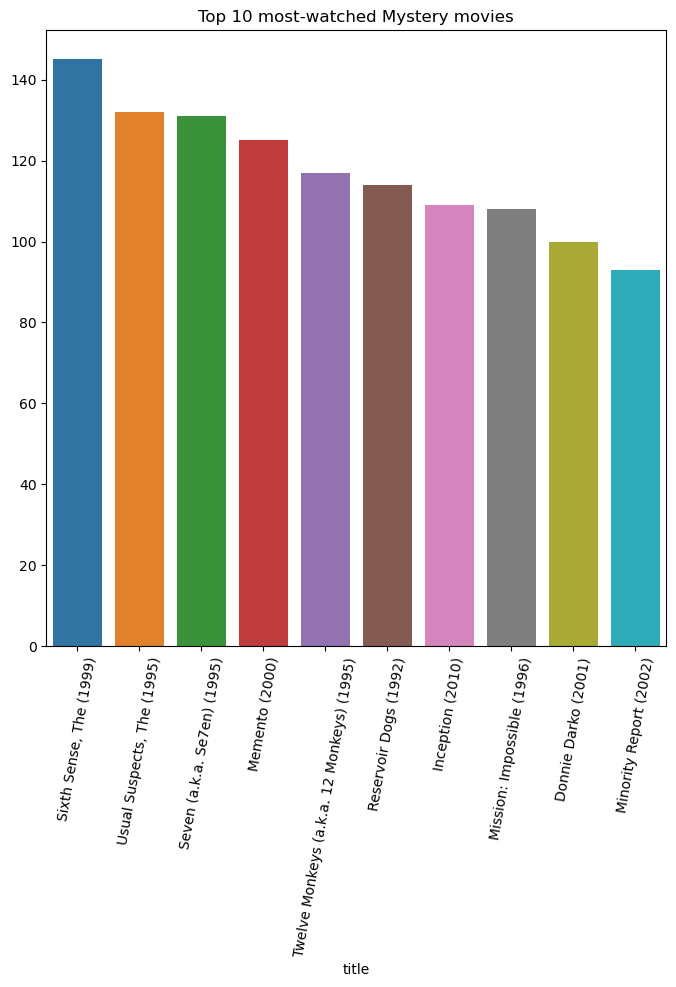

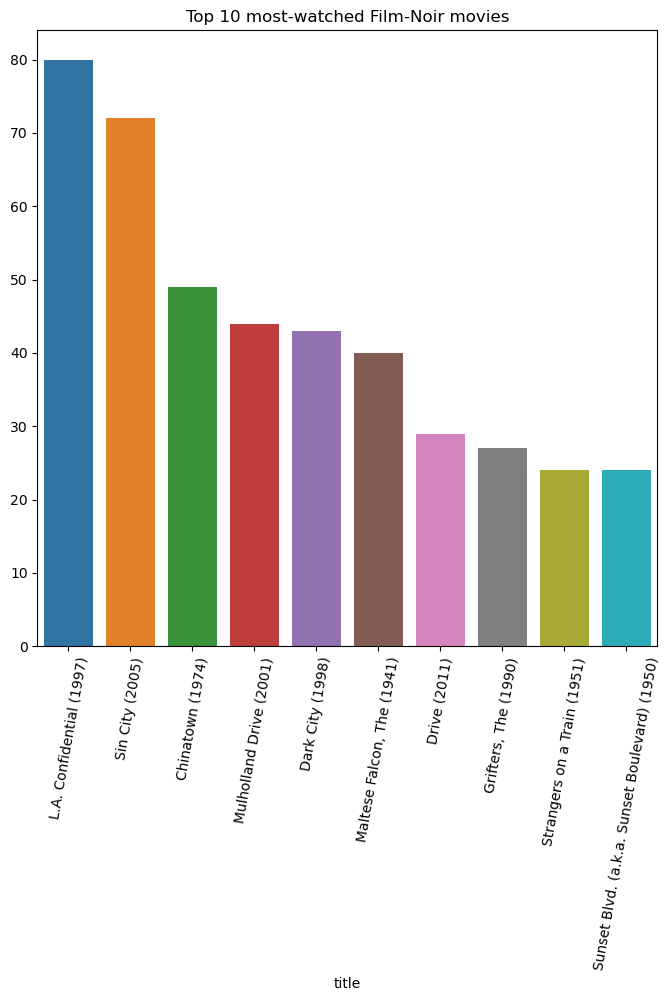

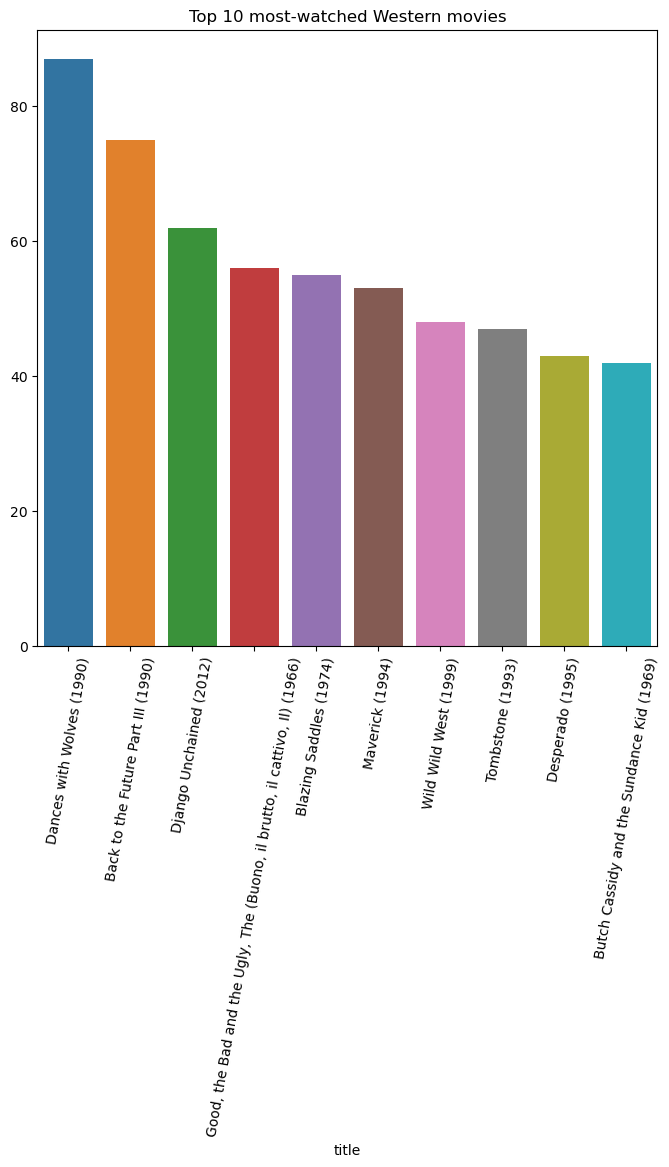

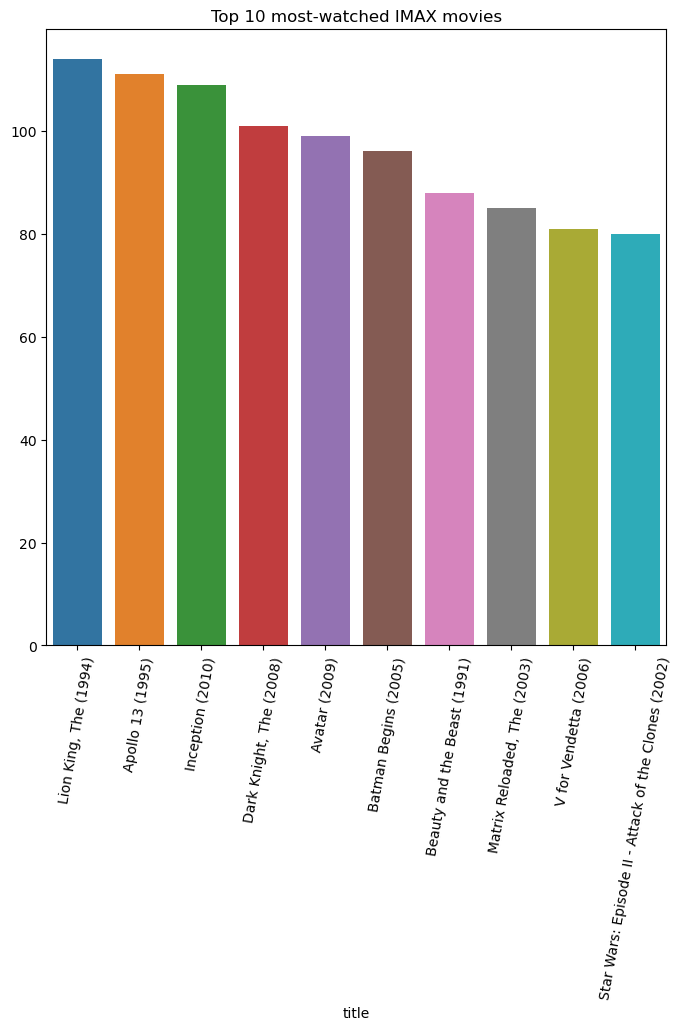

In [31]:
#Create a loop that will plot the top 10 most watched movies.  
for gen in matrix.columns[1:]:
    x = matrix[(matrix[gen]==True)]
    plt.figure(figsize=(8,8))
    topmovies = x.groupby('title').size().sort_values(ascending=False).head(10)
    sns.barplot(x=topmovies.index,y= topmovies.values)
    plt.title('Top 10 most-watched '+gen+' movies')
    plt.savefig('.\images\Main data\Top 10 most-watched '+gen+' movies')
    plt.xticks(rotation=80);

In [32]:
#Export the resulting data to a csv file 
data.to_csv('cleaneddata')

# Movie Recommendation System Models

In [33]:
#Create a new dataset with 'userId', 'movieId', 'rating'

df2 = df[['userId', 'movieId', 'rating']]
df2.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Use `surprise`'s built-in reader class to process data to work with recommender algorithms

In [34]:
#Instansiate reader and data 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df2, reader)

Train test split with test size of 20% 

In [35]:
#Train test split with test size of 20% 
trainset, testset = train_test_split(data, test_size=.2)

# Print number of uses and items for the trainset 
print('Number of users in train set : ', trainset.n_users, '\n')
print('Number of items in train set : ', trainset.n_items, '\n')

Number of users in train set :  610 

Number of items in train set :  8976 



### Baseline Model

baseline model will be a KNNBaseline model without any hyperparameters.

In [36]:
#Instansiate a baseline model using KNNBaseline 
baseline = KNNBaseline(random_state=42)

In [37]:
#Fit model on the trainset 
baseline.fit(trainset)

#Predict on the test set 
baselinepreds = baseline.test(testset)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [38]:
#Check RMSE and MAE results 
accuracy.rmse(baselinepreds)
accuracy.mae(baselinepreds)

RMSE: 0.8702
MAE:  0.6626


0.6625588388349332

The RMSE for our baseline is 0.8828 and the MAE is 0.6677. These are the values we will look to improve by attempting different models and including hyperparameters in future models. 

In [39]:
#Run 3-fold cross validation on the data and print results 
cv_baseline = cross_validate(baseline, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8799  0.8777  0.8785  0.8787  0.0009  
MAE (testset)     0.6693  0.6716  0.6687  0.6699  0.0013  
Fit time          0.68    0.48    0.38    0.52    0.13    
Test time         4.16    3.12    2.68    3.32    0.62    


In [40]:
# Print out the RMSE score for each fold 
for i in cv_baseline.items():
    print(i)

('test_rmse', array([0.87986694, 0.8777482 , 0.87854376]))
('test_mae', array([0.66932857, 0.6716009 , 0.66867713]))
('fit_time', (0.6847257614135742, 0.48386597633361816, 0.37768101692199707))
('test_time', (4.158576011657715, 3.1194794178009033, 2.6762845516204834))


In [41]:
#Find the average test RMSE from the 3-Fold cross-validation
np.mean(cv_baseline['test_rmse'])

0.8787196332852992

In [42]:
#Find the average test MAE from the 3-Fold cross-validation
np.mean(cv_baseline['test_mae'])

0.669868866557581

Our 3-fold cross validaiton has an average test RMSE of approximately 0.88. We will look to reduce this RMSE in future models.

### Model 1
cross validation on the whole data set using an SVD model and then I'll do a regular fit on the train data


In [43]:
svd = SVD(random_state = 15)

In [44]:
svd.fit(trainset)
preds = svd.test(testset)

accuracy.rmse(preds)
accuracy.mae(preds)

RMSE: 0.8656
MAE:  0.6613


0.661293026759312

In [45]:
SVD_cv = cross_validate(svd, data, cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8700  0.8635  0.8649  0.8568  0.8637  0.8638  0.0042  
MAE (testset)     0.6650  0.6575  0.6623  0.6538  0.6612  0.6600  0.0039  
Fit time          1.38    1.16    1.13    1.15    1.17    1.20    0.09    
Test time         0.13    0.14    0.36    0.16    0.36    0.23    0.11    


In [46]:
# Print out the average RMSE score for the test set
np.mean(SVD_cv['test_rmse'])


0.8637570040687541

In [47]:
# Print out the average RMSE score for the test set
np.mean(SVD_cv['test_mae'])


0.6599627719348413

Our 3-fold cross validaiton has an average test RMSE of approximately 0.8652, and a MAE of 0.6610

### Model 2

Our second model will be an SVD Model using GridSearch. We will first apply GridSearch to idently the best parameters that reduce our RMSE, and then will re-instantiate our model with these parameters so we can then fit on the trainset and predict on the test set.

In [48]:
#Set parameters for GridSearch on SVD model 
parameters = {'n_factors': [20, 50, 80],
             'reg_all': [0.04, 0.06],
             'n_epochs': [10, 20, 30],
             'lr_all': [.002, .005, .01]}
gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1)

In [49]:
#Fit SVD model on data
gridsvd.fit(data)

#Print best score and best parameters from the GridSearch 
print(gridsvd.best_score)
print(gridsvd.best_params)

{'rmse': 0.8475709158872314, 'mae': 0.6452840714848505}
{'rmse': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}, 'mae': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}}


In [50]:
#Reinstantiate the model with the best parameters fromGridSearch 
Gridsvdtuned = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)

#Fit and predict the model 
Gridsvdtuned.fit(trainset)
Gridsvdpreds = Gridsvdtuned.test(testset)

#Print RMSE and MAE results 
accuracy.rmse(Gridsvdpreds)
accuracy.mae(Gridsvdpreds)

RMSE: 0.8452
MAE:  0.6442


0.6441973165630941

Both our RMSE and MAE results are lower than in the baseline. Our SVD models are also improved because we have filtered out users and movies with lower ratings so that the sparsity of our matrix would decrease.

In [51]:
#Perform 3-Fold cross validation for SVD tuned model
cv_Gridsvd_tuned = cross_validate(Gridsvdtuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8571  0.8588  0.8552  0.8571  0.0015  
MAE (testset)     0.6542  0.6564  0.6513  0.6539  0.0021  
Fit time          1.69    1.59    1.25    1.51    0.19    
Test time         0.30    0.47    0.22    0.33    0.10    


In [52]:
#Display the results for all 3-folds 
for i in cv_Gridsvd_tuned.items():
    print(i)

('test_rmse', array([0.85713927, 0.85881587, 0.85524515]))
('test_mae', array([0.65415147, 0.65638916, 0.65130722]))
('fit_time', (1.686206579208374, 1.593371868133545, 1.2497048377990723))
('test_time', (0.2968013286590576, 0.46863889694213867, 0.21869659423828125))


In [53]:
# Print out the average RMSE score for the test set
np.mean(cv_Gridsvd_tuned['test_rmse'])


0.8570667646149808

In [54]:
#Find the average test MAE from the 3-Fold cross-validation
np.mean(cv_Gridsvd_tuned['test_mae'])

0.653949283998378

Our 3-fold cross validation test RMSE result was approx. 0.8567; a slight decrease from our baseline model 3-fold cross validation of 0.88.

### Model 3
Our next model will look at the KNNBasic algorithm to see if the results improve. We will again use GridSearch to look at different parameters in hopes of reducing our RMSE score.


In [55]:
# Set parameters to be used in KNN models 
knn_params = {'name': ['cosine', 'pearson'],
              'user_based':[True, False], 
              'min_support':[True, False],
            'min_k' : [1, 2]}

# Apply GridSearch to the KNN Basic model to identify the best parameters
Gridknnbasic = GridSearchCV(KNNBasic, knn_params, measures=['rmse', 'mae'], cv=3)

#Fit GridKnn model on data
Gridknnbasic.fit(data)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [56]:
#Display the best scores and parameters from GridSearch
print(Gridknnbasic.best_score)
print(Gridknnbasic.best_params)

{'rmse': 0.9460311937329902, 'mae': 0.7245583603016437}
{'rmse': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}, 'mae': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}}


In [57]:
#Reinstantiate the model with the best parameters from GridSearch 
Gridknnbasic_tuned = KNNBasic(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })

#Fit on the train set and predict on the test set 
Gridknnbasic_tuned.fit(trainset)
Gridknnbpreds = Gridknnbasic_tuned.test(testset)



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [58]:
#Print RMSE and MAE results 
accuracy.rmse(Gridknnbpreds)
accuracy.mae(Gridknnbpreds)

RMSE: 0.9650
MAE:  0.7421


0.7420904448105711

Both our RMSE and MAE results are higher than in the baseline.

In [59]:
#Perform 3-Fold cross validation Gridknnbasic model
cv_Gridknnbasic = cross_validate(Gridknnbasic_tuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9746  0.9754  0.9768  0.9756  0.0009  
MAE (testset)     0.7474  0.7505  0.7518  0.7499  0.0018  
Fit time          0.38    0.63    0.39    0.47    0.11    
Test time         2.28    2.63    2.53    2.48    0.15    


In [60]:
#Print the average RMSE score for the test set 
np.mean(cv_Gridknnbasic['test_rmse'])

0.9755959865853158

In [61]:
#Print the average MAE score for the test set 
np.mean(cv_Gridknnbasic['test_mae'])

0.7498717282626556

## Model 4
Our final model will look at the KNN Wtih Means algorithm, and apply a GridSearch similar to the KNN models above to tune our hyperparameters further.

In [62]:

#GridSearch Parameters
knn_params = {'name': ['cosine', 'pearson'],
              'user_based':[True, False], 
              'min_support':[True, False],
            'min_k' : [1, 2]}

#Apply GridSearch to the KNNWithMeans model 
GRIDknnWM = GridSearchCV(KNNWithMeans, knn_params, measures=['rmse', 'mae'], cv=3)
GRIDknnWM.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [63]:
#Display the best score and best parameters from GridSearch 
print(GRIDknnWM.best_score)
print(GRIDknnWM.best_params)

{'rmse': 0.8948828451364478, 'mae': 0.6822693972657222}
{'rmse': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}, 'mae': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}}


In [64]:
#Reinstansiate the model with the best parameters 
Gridknnwm_tuned = KNNWithMeans(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })


#Fit on the trainset, predict on the testset 
Gridknnwm_tuned.fit(trainset)
Gridknnwmpreds = Gridknnwm_tuned.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [65]:
#Print RMSE and MAE results
accuracy.rmse(Gridknnwmpreds)
accuracy.mae(Gridknnwmpreds)

RMSE: 0.9003
MAE:  0.6864


0.6863707505307631

### Observation
Both our RMSE and MAE results are higher than in the baseline.

In [66]:
#Perform 3-Fold cross validation on KNNWithMeans model 
cv_Gridknn_wm = cross_validate(Gridknnwm_tuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9052  0.9110  0.9009  0.9057  0.0041  
MAE (testset)     0.6930  0.6949  0.6869  0.6916  0.0034  
Fit time          0.38    0.76    0.40    0.52    0.18    
Test time         2.61    4.27    2.62    3.17    0.78    


In [67]:
#Print the average RMSE score for the test set 
np.mean(cv_Gridknn_wm['test_rmse'])



0.9056914591107988

In [68]:
#Print the average MAE score for the test set 
np.mean(cv_Gridknn_wm['test_mae'])

0.6915902743510811

### Observation
Both our average RMSE and average MAE results are higher than in the baseline.

### All results
Below we will take a look at all of the results for our models and compare them to the basline.

In [69]:
#Create a dictionary for each models' results 
baseline_result = {'model': 'baseline','RMSE': accuracy.rmse(baselinepreds), 'MAE': accuracy.mae(baselinepreds), 'CV_rmse': np.mean(cv_baseline['test_rmse']), 'CV_mae':np.mean(cv_baseline['test_mae'])}
svd_result = {'model':'svd', 'RMSE': accuracy.rmse(preds), 'MAE': accuracy.mae(preds), 'CV_rmse': np.mean(SVD_cv['test_rmse']),'CV_mae' : np.mean(SVD_cv['test_mae'])}
gridsvds_result = {'model':'Gridsvd', 'RMSE': accuracy.rmse(Gridsvdpreds), 'MAE': accuracy.mae(Gridsvdpreds),'CV_rmse': np.mean(cv_Gridsvd_tuned['test_rmse']) ,'CV_mae': np.mean(cv_Gridsvd_tuned['test_mae'])}
Gridknnbasic_result = {'model':'Gridknnbasic','RMSE': accuracy.rmse(Gridknnbpreds), 'MAE': accuracy.mae(Gridknnbpreds), 'CV_rmse': np.mean(cv_Gridknnbasic['test_rmse']),'CV_mae': np.mean(cv_Gridknnbasic['test_mae'])}
Gridknnwm_result = {'model':'Gridknnwm','RMSE': accuracy.rmse(Gridknnwmpreds), 'MAE': accuracy.mae(Gridknnwmpreds), 'CV_rmse': np.mean(cv_Gridknn_wm['test_rmse']), 'CV_mae': np.mean(cv_Gridknn_wm['test_mae'])}

RMSE: 0.8702
MAE:  0.6626
RMSE: 0.8656
MAE:  0.6613
RMSE: 0.8452
MAE:  0.6442
RMSE: 0.9650
MAE:  0.7421
RMSE: 0.9003
MAE:  0.6864


In [70]:
#Combine all the results into a list 
result_list = [baseline_result, svd_result, gridsvds_result, Gridknnbasic_result, Gridknnwm_result]

#Transform the results lists into a DataFrame 
df_results_updated = pd.DataFrame.from_dict(result_list, orient='columns')
df_results_updated = df_results_updated.set_index('model')

#Display the results for all of the models 
df_results_updated

,RMSE,MAE,CV_rmse,CV_mae
model,,,,
baseline,0.870152,0.662559,0.878720,0.669869
svd,0.865641,0.661293,0.863757,0.659963
Gridsvd,0.845207,0.644197,0.857067,0.653949
Gridknnbasic,0.965041,0.742090,0.975596,0.749872
Gridknnwm,0.900329,0.686371,0.905691,0.691590


Fortunately,  not all of our models perform worse than the baseline, the SVD model and GridSVD(SVD Model using GridSearch) performed better then the baseline model. 

GridSVD had an RMSE of 0.843416, compared to the baseline of 0.867823. 

Additionally, GridSVD MAE score was 0.643457 which is lower than the baseline result of 0.662120. 

Lastly, when performing 3-fold cross validation, our GridSVD_RMSE performs only slightly better than the baseline_RMSE with a result of 0.856712, compared to the baseline result of 0.876738 and our GridSVD_MAE performed better with 0.653887 than the baseline_MAE with a result of 0.668282.

As a result, we will disregard the KNN models for the remainder of our analysis and will move forward with our GridSVD tuned model, as it performed the best in terms of RMSE, MAE and CV.

Therefore, we can conclude that on average, our GridSVD model estimates ratings with an error of approximately 0.85. On a scale of 0-5, this 0.85 value is not too significant. Generally, with these models, we are trying to get a sense of what rating the user would rate a movie; and since these results are quite difficult to validate (we do not actually know if a user will enjoy a movie or not in reality), the estimation error of 0.85 is reasonably acceptable.

### Generating New Ratings 

We will create a function that generates ratings for a brand new user. We will then show how our model can use these ratings in order to make predictions. This step is important as it shows how our models and our recommendation systems can actually make predictions on new ratings!


In [71]:
#Define function that can generate new user movie ratings 
def movie_rater(movie_df,num, genre=None):
    #Create new user with userId = 1000
    userID = 1000
    
    #Create an empty list of ratings 
    rating_list = []
    
    #For all number of ratings, provide a random movie sample within the specified genre for the user to rate 
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
    
    #Provide user with a prompt to rate the movie, then print the userID, movieID, then title, then append 
    #results to the rating_list 
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'title':movie['title'].values[0], 'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list  

In [72]:
dfnew = df[['userId', 'movieId', 'rating', 'title', 'genres']]

In [73]:
userrating = movie_rater(dfnew, 3, 'Action')

       userId  movieId  rating                         title  \
58191     380    45499     4.0  X-Men: The Last Stand (2006)   

                       genres  
58191  Action|Sci-Fi|Thriller  


In [ ]:
## Display the new user ratings 
userrating_df=pd.DataFrame(userrating)
userrating_df

In [ ]:
#Add new ratings to our DataFrame
new_ratings_df = pd.concat([df2, userrating_df], ignore_index=True, sort=False)

In [ ]:
#Drop the 'title' column so that our dataframe is ready to be put into surprise
new_ratings_df.drop(['title'], axis=1, inplace=True)

In [ ]:
#Investigate new DataFrame
new_ratings_df.head()

Now we will redo the same modeling process as above in order to find predictions for the above movies.

In [ ]:
#Instansiate reader and data 
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(new_ratings_df, reader)

#Train test split of 20%
trainset, testset = train_test_split(data, test_size=.2)

#Reinstantiate the model with the best parameters from GridSearch and fit on the trainset 
Gridsvdtuned = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)

#Fit and predict the model 
Gridsvdtuned.fit(trainset)

In [ ]:
#Find predictions for the three movies that user with userId=1000 just rated
print(Gridsvdtuned.predict(1000,1240))
print(Gridsvdtuned.predict(1000,96610))
print(Gridsvdtuned.predict(1000,6534))

Now we have predictions for User 1000's movies that it has rated so far. We have now seen how our model can generate new ratings, and formulate predictions for these ratings as well.

# Extracting Predictions for all Users and Movies 

Our final step in the process will be to create a Dataframe that includes all the estimated ratings for every combination of userId and movieId. Once this information is clearly presented in a Dataframe, we will be able to conduct some post-modeling EDA to determine how or if trends from our estimators differ from our original ratings.

In [ ]:
#Create list of unique userIds and movieIds 
userids = new_ratings_df['userId'].unique()
movieids = new_ratings_df['movieId'].unique()


In [ ]:
#Create a list and append the userId, movieId, and estimated ratings 
predictions = [] 
for u in userids:
    for m in movieids:
        predicted = Gridsvdtuned.predict(u, m)
        predictions.append([u, m, predicted[3]])

In [ ]:
#Convert the list to a dataframe
estimated = pd.DataFrame(predictions)
estimated

In [ ]:
#rename columns of DataFrame 
estimated.rename(columns={0: 'userId', 1: 'movieId', 2:'estimatedrating'}, inplace=True)

In [ ]:
#Print the final dataFrame
estimated

We now have a DataFrame that includes every userId, and every movieId, along with their estimated ratings. We can now use this data to create visualizations that demonstrate any trends or patterns with our estimations data.

In [ ]:
#Export the estimated data to a csv file 
estimated.to_csv('estimated')

In [ ]:
user = 1000

#creating dataframe for user 1000 only
user1000 = estimated.loc[estimated['userId'] == user]
user1000

In [ ]:
# Merge user1000 with movies
user1000_movies = pd.merge(user1000, movies, on='movieId')
user1000_movies

### Building the Final Model

In [ ]:
#initialising final model with best params
final_model = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)

#Fitting the final model on the trainset
final_model.fit(trainset)

#Perform 3-Fold cross validation for SVD tuned model
cv_final_model = cross_validate(final_model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


In [ ]:
#Print the average RMSE score for the test set 
np.mean(cv_final_model['test_rmse'])


this model is  Aprox 86% accurate.

In [ ]:
user_id = user

#creating a list for unrated movies
unrated_movies_ids = [movie_id for movie_id in movies.movieId if movie_id not in ratings]

#creating a list for predictions
user_predictions = []

#looping through all movie ids
for movie_id in unrated_movies_ids:
    predicted = final_model.predict(user_id, movie_id).est
    
    #appending the results to the list
    user_predictions.append((movie_id, predicted))
    
#calling the prediction results and printing first 50 results   
user_predictions[:5]

In [ ]:
#sorting the predictions by the highest rated to lowest rated
ranked_predictions = sorted(user_predictions, key = lambda x: x[1], reverse = True)

#printing the top 50 rated movie ids
ranked_predictions[:5]

In [ ]:
def recommended_movies(user_predictions,movies,n):
    
    ranked_df = pd.DataFrame(user_predictions, columns = ['movieId', 'rating'])  
    
    # Merging user ratings with movie titles
    user_ratings = pd.merge(ranked_df, movies, on='movieId')
    
    # Sorting user's rated movies by their ratings in descending order (best to worst)
    user_ratings = user_ratings.sort_values(by='rating', ascending=False)
    
    top_n_recommendations = user_ratings.head(n)

    #Printing the recommended movies
    print(f"Top {n} Recommended Movies:")
    for index, row in top_n_recommendations.iterrows():
        print(f"Movie ID: {row['movieId']}, Title: {row['title']}")

In [ ]:
#calling the function for the top 5 for user 1000
recommended_movies(user_predictions,movies,5)

## Conclusion

Overall, our model does a fairly decent job of estimating users’ ratings, with an approximate error of 0.8563
Our model is a purely collaborative filtering model, and therefore does not address the “cold start problem”

Our future work would: look to incorporate aspects of a content based filtering model to address this